In [58]:
library(tidyverse)
options(repr.plot.width=4, repr.plot.height=3)

## Causal inference

We are interested in estimating the treatment effect ($Z$) on outcome variable $Y$.
For simplicity, we assume there is a single covariate $X$, which we assume to have zero mean.

## Randomized control trial

First we assume that the treatment $Z$ is independent of the covariate $X$.

In [196]:
gen.data = function(n, treatment.effect, p.treated, sigma) {
    X = rnorm(n)
    w.0 = rnorm(1)
    w.z = rnorm(1)

    # assignment
    Z = rbinom(n, 1, p.treated)

    # outcome
    Y = (Z * w.z + (1-Z) * w.0) * X + treatment.effect * Z + sigma * rnorm(n)
    data = tibble(y=Y, z=Z, x=X)
}

data = gen.data(n, treatment.effect, p.treated, sigma)

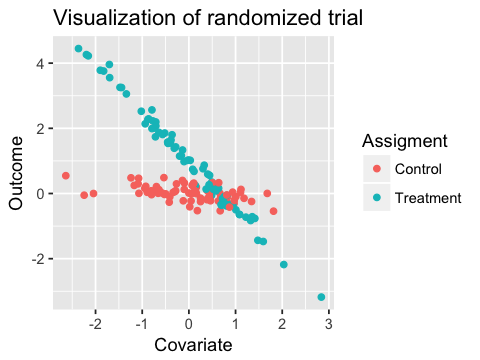

In [477]:
data = gen.data(150, 1, 0.5, 0.2)

ggplot(data) +
    geom_point(aes(x=x, y=y, color=factor(z))) +
    labs(title="Visualization of randomized trial", x="Covariate", y="Outcome") +
    scale_color_discrete(name="Assigment",
                         breaks=c(0, 1),
                         labels=c("Control", "Treatment"))


## Simple estimators of Average Treatment Effect

### Naive estimator

The naive estimator simply looks at the difference in mean outcome between the treatment and control group.
This works since it is a randomized control trial.
However, we can be more efficient as it does not control for the variance in $X$.

In [478]:
# naive estimate of treatment effect
naive.ate = function(data) {
    means = data %>% group_by(z) %>% summarise(mY.Z=mean(y))
    means$mY.Z[2] - means$mY.Z[1]
}

naive.ate(data)

[1] 1.01278

### Simple linear regression

Another simple estimator of the ATE regresses $Y$ on $Z$ and $X$. 
We can then read off the coefficient for $Z$ to find an estimator for the ATE.

However, this approaches blends the problem of estimating the ATE with the modeling decision to use a linear regression model.

In [479]:
# naive LM to estimate treatment effect
naive.lm.ate = function(data) {
    coef(lm(y ~ z + x, data=data))["z"]
}

naive.lm.ate(data)

z 
0.9873426

### Two linear models

We can separate the two concerns by fitting separate linear models.
We also note that this better fits the data, where the covariate has different effect on the outcome depending on the assignment.

In [480]:
# fit 2 lms
lm.ate = function(data) {
    data.Z0 = filter(data, z==0)
    data.Z1 = filter(data, z==1)

    lm.0 = lm(y ~ x, data=data.Z0)
    lm.1 = lm(y ~ x, data=data.Z1)

    mean(predict(lm.1, data) - predict(lm.0, data))
}

lm.ate(data)

[1] 0.9908068

## Asymptotics

Let's compare the asymptotics of the three estimators by generating many data sets.

In [527]:
n = 50
treatment.effect = 1
p.treated = 0.5
sigma = 0.2

nsim = 2000

In [528]:
experiment = function(generator, estimator) {
    data = generator()
    estimator(data)
}

# define the way we generate data
generator = function () gen.data(n, treatment.effect, p.treated, sigma)

simulate = function(nsim, estimator) replicate(nsim, experiment(generator, estimator))

In [529]:
naive.ests = simulate(nsim, naive.ate)
naive.lm.ests = simulate(nsim, naive.lm.ate)
lm.ests = simulate(nsim, lm.ate)

df.ests = tibble(estimator=c(rep("naive", nsim), rep("naive.lm", nsim), rep("lm", nsim)), 
                 estimate=c(naive.ests, naive.lm.ests, lm.ests))

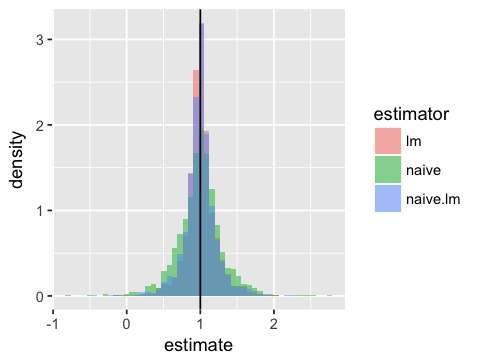

In [547]:
ggplot(df.ests) + 
    geom_histogram(aes(x=estimate, fill=estimator, y=..density..), alpha=0.5, position="identity", bins=50) +
    geom_vline(aes(xintercept=treatment.effect))
#     geom_density(aes(x=estimate, fill=estimator), alpha=0.1)

In [548]:
df.ests %>% group_by(estimator) %>% summarise(mse=mean((estimate-1)^2))

estimator,mse
lm,0.04507711
naive,0.09215967
naive.lm,0.05276226


We notice that the (double) linear model estimator of the causal effect performs best. 
The naive linear model is unable to pick up on the differences in slopes between the two models and thus has a slightly worse performance. 
The naive estimator that does not take the linearity of the data into account performs worst.

## Assignment dependent on covariate $X$

Now we consider the case where the assignment $Z$ is not random, but depends on the covariate $X$.
In this case, the above estimators do not work, as they do not take this into account.

For example, in the data we generate below, treatment is more likely when $X$ is large.

In [532]:
logit = function(x) {1/(1+exp(-x))}
invlogit = function(x) {log(x/(1-x))}

In [597]:
gen.x.data = function(n, sigma) {
    x = rnorm(n)

    # compute assignment
    z = rbinom(n, size=1, prob=logit(x))

    w = rnorm(1)
    w.z = rnorm(1)
    beta = rnorm(1)
    beta.z = rnorm(1)

    # generate true underlying data
    y.0.true = w + beta * x
    y.1.true = w.z + beta.z * x

    # generate outcome
    y = (1-z) * y.0.true + z * y.1.true + rnorm(n, 0, sigma)

    tibble(y=y, z=z, x=x, y0=y.0.true, y1=y.1.true, delta=y.1.true - y.0.true)
}

In [645]:
data = gen.x.data(200, 0.2)

In [646]:
head(data)

y,z,x,y0,y1,delta
-1.0015910,1,1.65858397,3.050151,-0.96884716,-4.018998
0.7399723,0,0.06772889,0.970532,0.04748902,-0.923043
-0.5191929,1,0.88101190,2.033683,-0.47208624,-2.505769
-0.7888259,1,1.46385471,2.795594,-0.84444212,-3.640036
-0.7877895,1,1.00568116,2.196654,-0.55173264,-2.748387
-1.5338702,0,-1.95742074,-1.676811,1.34127929,3.018090


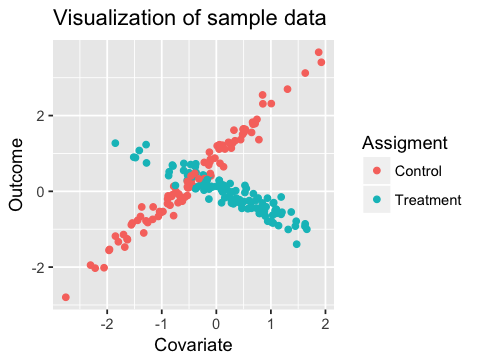

In [761]:
ggplot(data) + geom_point(aes(x=x, y=y, color=factor(z))) +
    labs(title="Visualization of sample data", x="Covariate", y="Outcome") +
    scale_color_discrete(name="Assigment",
                         breaks=c(0, 1),
                         labels=c("Control", "Treatment"))

In [648]:
true.ate = mean(data$y1 - data$y0)
true.ate

[1] -0.6804788

## Inverse propensity weighting

To adjust for the non-random assignment, we can use inverse propensity weighting:
we weight each observation by the inverse of the probability of seeing the assignment.

In [649]:
ps.model = glm(z ~ x, data, family="binomial")
ps = predict(ps.model, data, type="response")

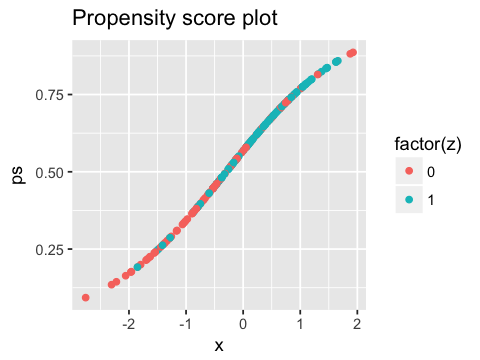

In [650]:
ggplot(data) + 
geom_jitter(aes(x=x, y=ps, color=factor(z))) + 
labs(title="Propensity score plot")

In [653]:
ipw.ate = function(data) {
    ps.model = glm(z ~ x, data, family="binomial")
    ps = predict(ps.model, data, type="response")
    mean(data$z * data$y / ps - (1-data$z) * data$y / (1-ps))
}

In [654]:
ipw.ate(data)

[1] -0.9174707

## Doubly-robust estimator

Doubly robust estimator based on propensity scores

In [655]:
dr.ate = function(data) {
    ps.model = glm(z ~ x, data, family="binomial")
    ps = predict(ps.model, data, type="response")

    lm.0 = lm(y ~ x, data=filter(data, z==0))
    lm.1 = lm(y ~ x, data=filter(data, z==1))

    y.h0 = predict(lm.0, data)
    y.h1 = predict(lm.1, data)

    y.dr = y.h1 - y.h0 + data$z * (data$y-y.h1)/ps - (1-data$z) * (data$y-y.h0)/(1-ps)
    mean(y.dr)
    
    # alternative, but equivalent, formulation of DR estimator
    # mean(z*y/ps - (z-ps)/ps * y.h1 - (1-z)*y/(1-ps) - (z-ps)/(1-ps) * y.h0)
}

In [656]:
dr.ate(data)

[1] -0.7080328

In [657]:
n = 500
nsim = 200
sigma = 0.2

In [658]:
experiment.x = function(generator, estimator) {
    data = generator()
    true.ate = mean(data$y1 - data$y0)
    
    estimator(data) - true.ate
}

lm.errs = replicate(nsim, experiment.x(function() gen.x.data(n, sigma), lm.ate))
ipw.errs = replicate(nsim, experiment.x(function() gen.x.data(n, sigma), ipw.ate))
dr.errs = replicate(nsim, experiment.x(function() gen.x.data(n, sigma), dr.ate))
    
df.errs = tibble(estimator=c(rep("lm", nsim), rep("ipw", nsim), rep("dr", nsim)), 
             estimate=c(lm.errs, ipw.errs, dr.errs))

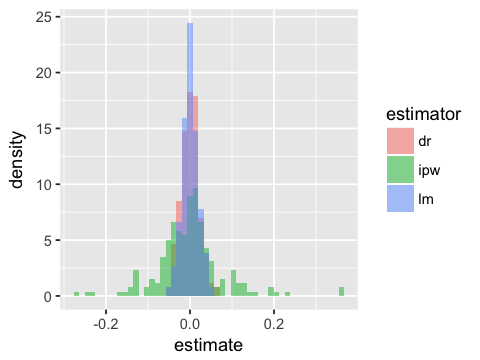

In [663]:
ggplot(df.errs) + 
    geom_histogram(aes(x=estimate, fill=estimator, y=..density..), alpha=0.5, position="identity", bins=50)
#     geom_density(aes(x=estimate, fill=estimator), alpha=0.1)

In [667]:
df.errs %>% group_by(estimator) %>% summarise(mse=mean(estimate^2))

estimator,mse
dr,0.0004500483
ipw,0.0063144789
lm,0.0003630231


We see that in the logistic treatment and linear response model, the doubly robust model and the naive estimator lead to similar performance.
The IPW estimator is not able to use a linear model to reduce the variance and thus suffers from larger variance.

## Misspecified propensity model

In [744]:
gen.xps.data = function(n, sigma) {
    x = rnorm(n)

    # compute assignment
    z = rbinom(n, size=1, prob=logit(3*cos(2*x+0.4)))

    w = rnorm(1)
    w.z = rnorm(1)
    beta = rnorm(1)
    beta.z = rnorm(1)

    # generate true underlying data
    y.0.true = w + beta * x
    y.1.true = w.z + beta.z * x

    # generate outcome
    y = (1-z) * y.0.true + z * y.1.true + rnorm(n, 0, sigma)

    tibble(y=y, z=z, x=x, y0=y.0.true, y1=y.1.true, delta=y.1.true - y.0.true)
}

In [745]:
data.xps = gen.xps.data(200, 0.2)

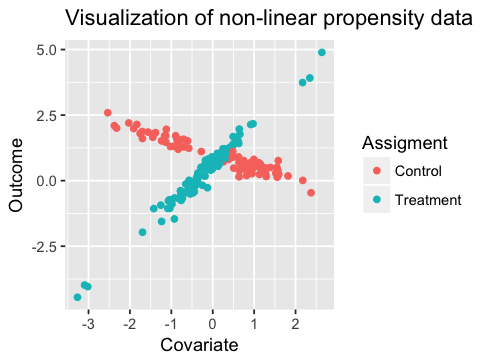

In [762]:
ggplot(data.xps) + geom_point(aes(x=x, y=y, color=factor(z))) +
    labs(title="Visualization of non-linear propensity data", x="Covariate", y="Outcome") +
    scale_color_discrete(name="Assigment",
                         breaks=c(0, 1),
                         labels=c("Control", "Treatment"))

In [747]:
lm.errs.ps = replicate(nsim, experiment.x(function() gen.xps.data(n, sigma), lm.ate))
ipw.errs.ps = replicate(nsim, experiment.x(function() gen.xps.data(n, sigma), ipw.ate))
dr.errs.ps = replicate(nsim, experiment.x(function() gen.xps.data(n, sigma), dr.ate))
    
df.errs.ps = tibble(estimator=c(rep("lm", nsim), rep("ipw", nsim), rep("dr", nsim)), 
             estimate=c(lm.errs.ps, ipw.errs.ps, dr.errs.ps))

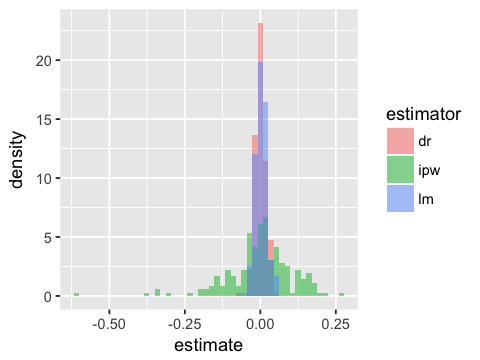

In [748]:
ggplot(df.errs.ps) + 
    geom_histogram(aes(x=estimate, fill=estimator, y=..density..), alpha=0.5, position="identity", bins=50)
#     geom_density(aes(x=estimate, fill=estimator), alpha=0.1)

In [749]:
df.errs.ps %>% group_by(estimator) %>% summarise(mse=mean(estimate^2))

estimator,mse
dr,0.0003074850
ipw,0.0119116673
lm,0.0003559048


Here we notice that the naive linear model and the doubly robust estimator clearly outperform the IPW estimator.
This makes sense as the IPW estimator is not able to estimate propensity scores accurately.
The doubly robust estimator also uses the same faulty propensity scores, but is robust to the errors 
because the linear response model still holds.

## Misspecified linear model

In [750]:
gen.xln.data = function(n, sigma) {
    x = rnorm(n)

    # compute assignment
    z = rbinom(n, size=1, prob=logit(x))

    w = rnorm(1)
    w.z = rnorm(1)

    # generate true underlying data
    y.0.true = w + 2*cos(x)
    y.1.true = w.z + 2*sin(x)

    # generate outcome
    y = (1-z) * y.0.true + z * y.1.true + rnorm(n, 0, sigma)

    tibble(y=y, z=z, x=x, y0=y.0.true, y1=y.1.true, delta=y.1.true - y.0.true)
}

In [751]:
data.xln = gen.xln.data(200, 0.2)

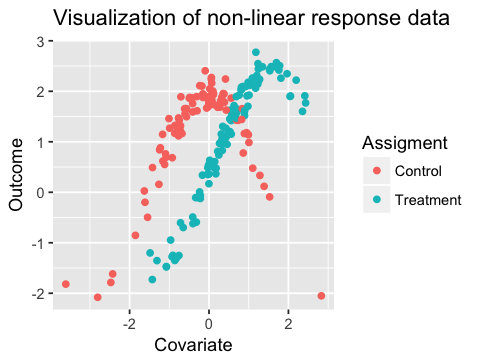

In [763]:
ggplot(data.xln) + geom_point(aes(x=x, y=y, color=factor(z))) +
    labs(title="Visualization of non-linear response data", x="Covariate", y="Outcome") +
    scale_color_discrete(name="Assigment",
                         breaks=c(0, 1),
                         labels=c("Control", "Treatment"))

In [753]:
lm.errs.ln = replicate(nsim, experiment.x(function() gen.xln.data(n, sigma), lm.ate))
ipw.errs.ln = replicate(nsim, experiment.x(function() gen.xln.data(n, sigma), ipw.ate))
dr.errs.ln = replicate(nsim, experiment.x(function() gen.xln.data(n, sigma), dr.ate))
    
df.errs.ln = tibble(estimator=c(rep("lm", nsim), rep("ipw", nsim), rep("dr", nsim)), 
             estimate=c(lm.errs.ln, ipw.errs.ln, dr.errs.ln))

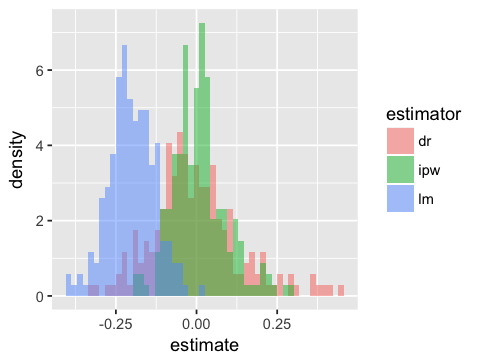

In [758]:
ggplot(df.errs.ln) + 
    geom_histogram(aes(x=estimate, fill=estimator, y=..density..), 
                   alpha=0.5, position="identity", bins=50)

In [759]:
df.errs.ln %>% group_by(estimator) %>% summarise(mse=mean(estimate^2))

estimator,mse
dr,0.018712312
ipw,0.007150676
lm,0.045558139


In this case, we notice that IPW works best; that makes sense as any linear model is worthless.
It's also clear that the purely linear model is terrible at estimating the effect and produces bad estimates.
However, the doubly robust estimator is still reasonable in this case. It's variance is clearly worse than the IPW estimator, but it is unbiased as the theory suggests and much better than the naive estimator.